<h1><center>🚸 GTSRB German Road Signs (Convolutional Neural Network) 🚸</center></h1>
<p><center><i>By Natan Szczepaniak</i></center></p>

<img width="400px" src="road_signs_header.jpeg"/>

Convolutional Neural Network.......

In [2]:
# Uncomment if missing dependencies
# !pip3 install wget tensorflow numpy matplotlib Pillow pandas tqdm scitkit-learn

## 📊 Download, Preprocess and put image data into numpy arrays

The code below downloads the dataset from the ERDA website (if not downloaded already) and loads it into a neat format in a numpy array.

Unfortunately the images are not of uniform shape which would make it difficult to train our model on as it would mean irregular input parameters, this means we need to resize the images to 30x30x3 dimensions. Usually I would do this once, save the dataset and load it in later but I did this verbosely for demonstration purposes.

The [source of the data](https://benchmark.ini.rub.de) provided a sample code to load in the data from their website however it was written in Python2 using outdated libraries so I redid it myself.

In [3]:
import os
import wget
import zipfile
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
from numpy.random import choice
import pandas as pd
from PIL import Image
from tqdm import tqdm
from tensorflow import keras
from tensorflow.math import confusion_matrix
import seaborn as sns

from road_labels import label_name
from colours import colour

# check TF version
print("TensorFlow Version: " + tf.__version__)

TensorFlow Version: 2.8.0


In [4]:
### LOAD IN THE DATASET (276MB) ###

# Image Constants & Dimensions
IMG_WIDTH = 40
IMG_HEIGHT = 40
CHANNELS = 3
CLASSES = 43

# Location of data
CUR_DIR = os.getcwd()
URL = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip"

In [5]:
# Function to load in data given a path
def load_roadsigns(path):
    '''Reads traffic sign data and resizes to the correct WIDTH and HEIGHT for training.
    '''
    
    # Initialise the output arrays
    X = [] # images
    y = np.array([]) # labels
    
    print("Resizing images...")
    # Iterate through all the directories, pull out images and resize
    for i in range(CLASSES):
        
        # Messing around with paths of where the data is found
        class_label = f"{i:05}"
        class_folder = path+f"/{class_label}"
        datasheet = pd.read_csv(class_folder+f"/GT-{class_label}.csv",delimiter=";")

        image_files = list(datasheet["Filename"])
        labels = list(datasheet["ClassId"])
        
        y = np.append(y,labels)
        
        # Open each image, resize and save into numpy array
        for image_file in tqdm(image_files):
            try: 
                image = Image.open(class_folder+"/"+image_file) 
                image = image.resize((IMG_WIDTH,IMG_HEIGHT)) 
                image = np.array(image)
                X.append(image)
            except: 
                print("Erorr loading in image")
                break
                
    # Converting to numpy arrays
    # It was actually quicker to do the appending in native lists and converting lol ¯\_(ツ)_/¯
    X = np.array(X)
    y = y.astype(int)
                
    return X, y

In [6]:
# Check if file already downloaded
if not os.path.isfile("GTSRB_Final_Training_Images.zip"):
    if not os.path.isdir("GTSRB"):
        print("Downloading Dataset...")
        wget.download(URL,".")
        print("Downloaded!")
        
        # Unzip the file into a folder
        with zipfile.ZipFile("GTSRB_Final_Training_Images.zip","r") as zip_ref:
            zip_ref.extractall(".")
        
        os.remove("GTSRB_Final_Training_Images.zip")
    else:
        print("Dataset already downloaded.")
else:
    print("Dataset already downloaded.")
    
# Load in dataset into memory
X, y = load_roadsigns("GTSRB/Final_Training/Images")
X = X/255

Dataset already downloaded.
Resizing images...


100%|███████████████████████████████████████| 240/240 [00:00<00:00, 1223.24it/s]


# 🌎 Data Exploration
Now that the dataset is downloaded and reshaped to 30x30x3 dimensions we can look at what the images actually look like and the labels that are available to us.

I have created a seperate python module which holds the corresponding names for label numbers. This is in a form of a simple dictionary which can be referenced for ease of use and to reduce bloated code in this notebook.

In [7]:
print(f"Dimensions of images array: {X.shape}")
print(f"Dimensions of labels array: {y.shape}")

Dimensions of images array: (39209, 40, 40, 3)
Dimensions of labels array: (39209,)


We have around ~40k images to play around with making this a sizable dataset to split up for training, testing and validation. Before we do this though, lets explore the images some more.

In [8]:
maps = ["Reds","Greens","Blues"]

# Here we can visualise our images and their corresponding labels
def plot_sign(X,y,n):
    plt.imshow(X[n])
    plt.title(label_name[y[n]])

def plot_sign_rgb(X,y,n):
    fig, ax = plt.subplots(1,CHANNELS,figsize=(10,10))
    for i in range(CHANNELS):
        ax[i].imshow(X[n][:, :, i],cmap=maps[i])
        ax[i].title.set_text(str(maps[i]))

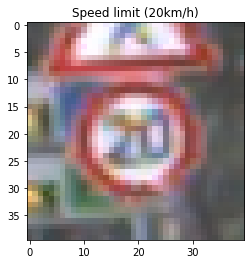

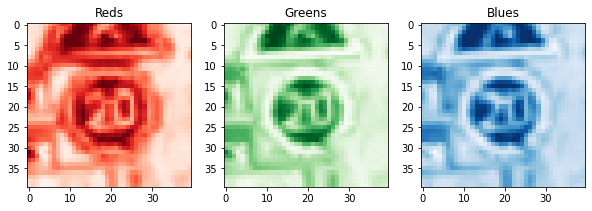

In [9]:
# Change index to see image and associated label
n = 0

# Plots actual image
plot_sign(X,y,n)
# Plots RGB decomposition, the darker the higher value
plot_sign_rgb(X,y,n)

# MAKE SURE TO ADD ONE FIG WHICH SHOWS ALL CLASSES

<AxesSubplot:title={'center':'Class Distribution of Images'}, xlabel='label_name', ylabel='no. of images'>

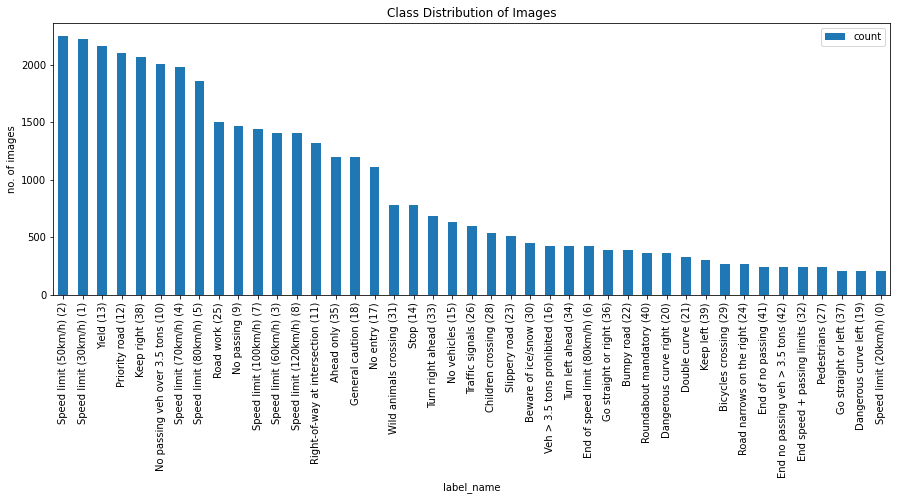

In [10]:
def format_label(label):
    return label_name[label]+f" ({label})"

# Plotting the distribution of the data
dist = pd.DataFrame({"label":np.unique(y),"count":np.bincount(y)})
dist["label_name"] = dist["label"].apply(format_label)
dist = dist.sort_values("count",ascending=False)

dist.plot(kind="bar",x="label_name",y="count",figsize=(15,5),title="Class Distribution of Images",ylabel="no. of images")

In [11]:
dist

,label,count,label_name
2,2,2250,Speed limit (50km/h) (2)
1,1,2220,Speed limit (30km/h) (1)
13,13,2160,Yield (13)
12,12,2100,Priority road (12)
38,38,2070,Keep right (38)
10,10,2010,No passing veh over 3.5 tons (10)
4,4,1980,Speed limit (70km/h) (4)
5,5,1860,Speed limit (80km/h) (5)
25,25,1500,Road work (25)
9,9,1470,No passing (9)


We can clearly see by this that this dataset is extremely skewed. There are 2250 images for the **Speed limit (50km/h)** and only 210 images for the **Speed limit (20km/h)** class.

This would make any model we make into being biased or perform better the classes with more training images. To address this we can create more data by rotating, transforming and resizing the images.

Before this however we need to split the data into Test/Train/Validation datasets.

# 🖖 Splitting the Data

For training, testing and validation purposes, we must split the data into datasets that retain the ratios of images available.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=True)

In [13]:
# See shape of the train and test datasets
print(f"Train dataset shape: {X_train.shape}")
print(f"Validation dataset shape: {X_val.shape}")
print(f"Test dataset shape: {X_test.shape}")

Train dataset shape: (28230, 40, 40, 3)
Validation dataset shape: (3137, 40, 40, 3)
Test dataset shape: (7842, 40, 40, 3)


In order to sanity check if the training and validation sets have enough images for the classes with the least samples.

In [14]:
# Plotting the distribution of the training data
train_dist = pd.DataFrame({"label":np.unique(y_train),"count":np.bincount(y_train)})
train_dist["label_name"] = train_dist["label"].apply(format_label)
train_dist = train_dist.sort_values("count",ascending=False)

# Plotting the distribution of the val data
val_dist = pd.DataFrame({"label":np.unique(y_val),"count":np.bincount(y_val)})
val_dist["label_name"] = val_dist["label"].apply(format_label)
val_dist = val_dist.sort_values("count",ascending=False)

print(colour.BOLD+"Training least samples:"+colour.END)
print(train_dist[-10:])
print(colour.BOLD+"\nValidation least samples:"+colour.END)
print(val_dist[-10:])

Training least samples:
    label  count                          label_name
39     39    220                      Keep left (39)
24     24    195      Road narrows on the right (24)
29     29    193              Bicycles crossing (29)
42     42    183  End no passing veh > 3.5 tons (42)
32     32    183     End speed + passing limits (32)
41     41    182              End of no passing (41)
27     27    180                    Pedestrians (27)
0       0    158            Speed limit (20km/h) (0)
37     37    154            Go straight or left (37)
19     19    154           Dangerous curve left (19)

Validation least samples:
    label  count                          label_name
39     39     22                      Keep left (39)
29     29     18              Bicycles crossing (29)
42     42     16  End no passing veh > 3.5 tons (42)
32     32     16     End speed + passing limits (32)
24     24     16      Road narrows on the right (24)
0       0     14            Speed limit (20km/h)

The lowest amount of samples in the training dataset is 154 which is low compared to the 2000 high but with data augmentation we can tackle this. The validation dataset only has 9 images for class 37 which is low but I can live with it.

# 🤖 Data Augmentation

Biggest issue with this dataset is the skewedness of the images available for each class. If used for training, this would lead to some classes being predicted with higher accuracy than others. The model could also be skewed towards these samples.

To combat this we can generate some more data by rotating, shifting, shearing and zooming. For this example I have chosen a rotation of 20 degrees (as roadsigns wouldnt rotate that much irl, also any more would mess up arrow directions) and shift of 10% together with a "reflect" mode which fills in the area of the image with a reflecting image.

Doing this will prevent overfitting and allow the network to generalise better.

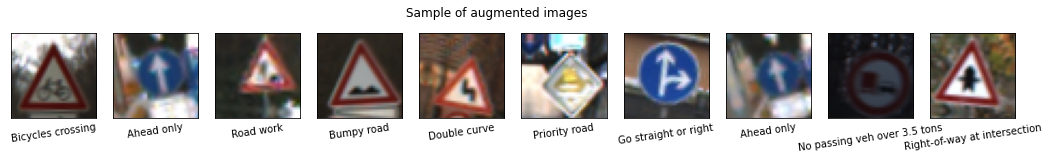

In [15]:
datagen = ImageDataGenerator(
    rotation_range=20, # Rotate randomly from 0 to 20 (not too far)
    height_shift_range=0.1,
    width_shift_range=0.1,
    horizontal_flip=False,
    fill_mode="reflect")

# Fits data to allow for augmentation with the flow method
datagen.fit(X_train)

# Visualise a sample of the augmented images
fig, ax = plt.subplots(1,10,figsize=(18,2))
fig.suptitle("Sample of augmented images")

# Visualise the transformations on the images. (seed set to prevent changing results.)
for X_batch, y_batch in datagen.flow(X_train, y_train,shuffle=False):    
    for i in range(0, 10):
        ax[i].imshow(X_batch[i])
        ax[i].set_xlabel(label_name[y_batch[i]],rotation=8)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    # break out of the loop before it goes on...
    break

In [134]:
AUG_COUNT = 2000
BATCH_SIZE = 32

# I will save the augmented with equal amounts of
# image classes in numpy arrays
# Usually you wouldnt waste memory like this but I
# want to compare the accuracy of model with and without augmentation.
X_train_aug = []
y_train_aug = []

# Iterate over each class and 
# generate AUG_COUNT augmented images
for class_ in range(CLASSES):
    print(f"{class_+1}/{CLASSES} Generating data for class: {label_name[class_]}")
    indices = [i for i, x in enumerate(y_train) if x == class_]  # Get indexes of all instances of that class
    
    for i in tqdm(range(AUG_COUNT)):
        img_to_transform = X_train[choice(indices)]
        transformed_img = datagen.random_transform(img_to_transform)
        
        X_train_aug.append(transformed_img)
        y_train_aug.append(class_)

X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

# THIS IS AN ALTERNATIVE METHOD HOWEVER IT PERFORMED BADLY    

# This for loop should create a balanced dataset (inefficient af but fix for another time)
# for X_batch, y_batch in datagen.flow(X_train, y_train,seed=42,batch_size=BATCH_SIZE):
#     for i in range(BATCH_SIZE):
#         class_count = train_dist_sorted.at[y_batch[i],"aug_count"]
#         if class_count != AUG_COUNT:
#             X_train_aug.append(X_batch[i])
#             y_train_aug.append(y_batch[i])
#             train_dist_sorted.at[y_batch[i],"aug_count"] = class_count + 1
#         else:
#             print(f"Class: {label_name[y_batch[i]]} is filled to {AUG_COUNT}!")

1/43 Generating data for class: Speed limit (20km/h)


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1453.30it/s]


2/43 Generating data for class: Speed limit (30km/h)


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1454.77it/s]


3/43 Generating data for class: Speed limit (50km/h)


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1462.46it/s]


4/43 Generating data for class: Speed limit (60km/h)


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1517.38it/s]


5/43 Generating data for class: Speed limit (70km/h)


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1423.20it/s]


6/43 Generating data for class: Speed limit (80km/h)


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1344.41it/s]


7/43 Generating data for class: End of speed limit (80km/h)


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1525.46it/s]


8/43 Generating data for class: Speed limit (100km/h)


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1420.92it/s]


9/43 Generating data for class: Speed limit (120km/h)


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1464.97it/s]


10/43 Generating data for class: No passing


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1422.20it/s]


11/43 Generating data for class: No passing veh over 3.5 tons


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1209.30it/s]


12/43 Generating data for class: Right-of-way at intersection


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1501.69it/s]


13/43 Generating data for class: Priority road


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1406.64it/s]


14/43 Generating data for class: Yield


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1100.08it/s]


15/43 Generating data for class: Stop


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1153.36it/s]


16/43 Generating data for class: No vehicles


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1631.60it/s]


17/43 Generating data for class: Veh > 3.5 tons prohibited


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1694.55it/s]


18/43 Generating data for class: No entry


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1416.00it/s]


19/43 Generating data for class: General caution


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1548.78it/s]


20/43 Generating data for class: Dangerous curve left


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1661.32it/s]


21/43 Generating data for class: Dangerous curve right


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1575.24it/s]


22/43 Generating data for class: Double curve


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1139.03it/s]


23/43 Generating data for class: Bumpy road


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1717.68it/s]


24/43 Generating data for class: Slippery road


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1672.29it/s]


25/43 Generating data for class: Road narrows on the right


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1409.86it/s]


26/43 Generating data for class: Road work


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1517.66it/s]


27/43 Generating data for class: Traffic signals


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1649.26it/s]


28/43 Generating data for class: Pedestrians


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1279.40it/s]


29/43 Generating data for class: Children crossing


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1369.79it/s]


30/43 Generating data for class: Bicycles crossing


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1538.48it/s]


31/43 Generating data for class: Beware of ice/snow


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1042.21it/s]


32/43 Generating data for class: Wild animals crossing


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1302.42it/s]


33/43 Generating data for class: End speed + passing limits


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1208.77it/s]


34/43 Generating data for class: Turn right ahead


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1262.53it/s]


35/43 Generating data for class: Turn left ahead


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1128.92it/s]


36/43 Generating data for class: Ahead only


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1268.78it/s]


37/43 Generating data for class: Go straight or right


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1507.00it/s]


38/43 Generating data for class: Go straight or left


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1516.48it/s]


39/43 Generating data for class: Keep right


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1422.80it/s]


40/43 Generating data for class: Keep left


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1640.58it/s]


41/43 Generating data for class: Roundabout mandatory


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1159.54it/s]


42/43 Generating data for class: End of no passing


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1405.09it/s]


43/43 Generating data for class: End no passing veh > 3.5 tons


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1398.79it/s]


In [135]:
# Get the class distribution of the train augmented dataset
train_aug_dist = pd.DataFrame({"label":np.unique(y_train_aug),"count":np.bincount(y_train_aug)})
train_aug_dist["label_name"] = train_aug_dist["label"].apply(format_label)
train_aug_dist = train_aug_dist.sort_values("count",ascending=False)

train_aug_dist.head()

,label,count,label_name
0,0,2000,Speed limit (20km/h) (0)
32,32,2000,End speed + passing limits (32)
24,24,2000,Road narrows on the right (24)
25,25,2000,Road work (25)
26,26,2000,Traffic signals (26)


Shape of the Augmented X: (86000, 40, 40, 3)
Shape of the Augmented y: (86000,)


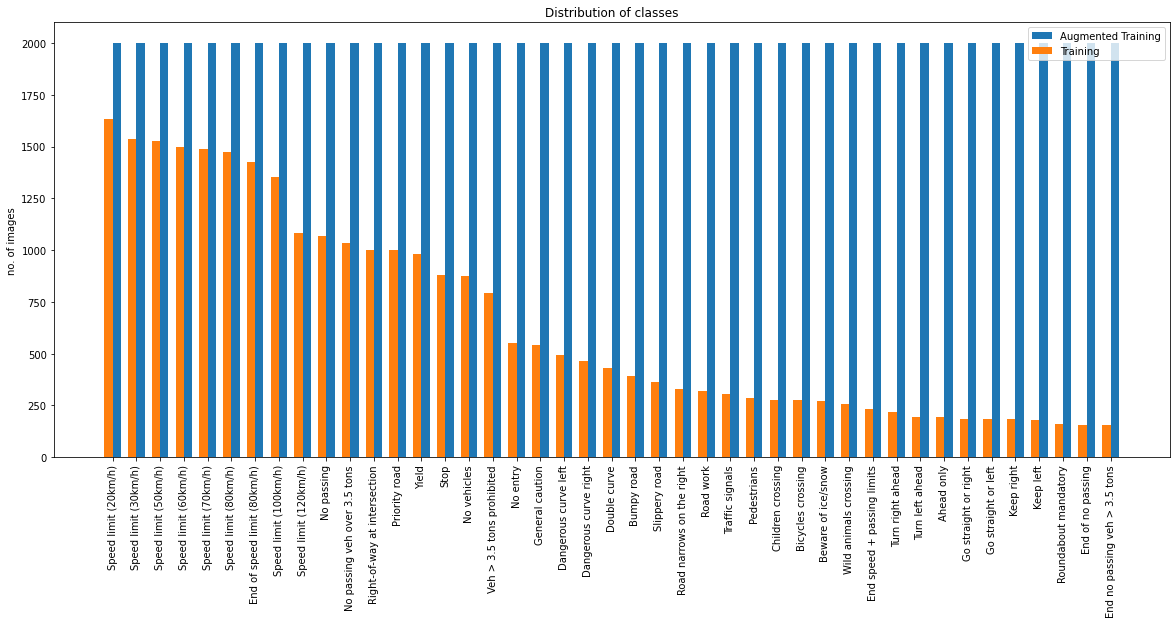

In [136]:
# Plot Training vs Augmented Training Datsets
#
# train_dist - before augmentation
# train_aug_dist - after augmentation
#

x = np.arange(len(train_dist["label"])) # the label locations
labels = list(label_name.values())
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,8))

train_aug = ax.bar(x + width/2, train_aug_dist["count"], width, label='Augmented Training')
train = ax.bar(x - width/2, train_dist["count"], width, label='Training')

ax.set_xticks(x,labels,rotation=90)
ax.set_ylabel('no. of images')
ax.set_title('Distribution of classes')

ax.legend()
print(f"Shape of the Augmented X: {X_train_aug.shape}")
print(f"Shape of the Augmented y: {y_train_aug.shape}")

Here FINALLY we can see that all of the classes have the same amount of images. Our data is ready for our model!!!!

#### To recap, our data is:
1. Downloaded
2. Resized to 30x30x3
3. Split to Test,Train,Validate
4. Train dataset has been augmented to equalise classes


# 🏗️ Model Construction 

To test out how effective our CNN model is, we will test out 3 different architecutres.

Model Alpha - no convolution layer
Model Beta - Simple CNN with 32 filters, a dropout
Model Gamma - Two iterations of Convolution layers then a huge 512 dense network. (Architecture from)

We expect model alpha to not generalise as well as 

In [16]:
model_alpha = keras.Sequential([
    # Neural Network
    keras.layers.Flatten(input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS)),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(64,activation='relu'),
    
    # Output
    keras.layers.Dense(43,activation = 'softmax')
])

model_beta = keras.Sequential([
    # Convolution
    keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS)),
    keras.layers.MaxPooling2D(pool_size=2) ,
    keras.layers.Dropout(0.2),
    
    #Neural Network
    keras.layers.Flatten(),
    keras.layers.Dense(32,activation='relu'),
    
    # Output
    keras.layers.Dense(43,activation = 'softmax')
    
])

model_gamma = keras.models.Sequential([
    # Convolution Layer
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    # Convolution Layer
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    # Neural Network
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])


2022-04-06 09:22:20.996246: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
model_alpha.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])


In [139]:
epochs = 20
#model.fit(X_train, y_train, batch_size=32, epochs=epochs)

In [140]:
#model.evaluate(X_test,y_test)

In [141]:
#plot_sign(X_test,y_test,10)

In [142]:
# predictions = model.predict(X_test)
# predictions = np.argmax(predictions,axis=1)

In [143]:
# # Pick a number
# n = 100

# # Plot and check if prediction matches
# plot_sign(X_test,y_test,n)
# print(colour.BOLD+f"Model Predicted: {label_name[predictions[n]]}"+colour.END)

In [144]:
# cm_mat = np.array(confusion_matrix(y_test,predictions)).astype(int)

# cm_df = pd.DataFrame(cm_mat, index = [i for i in labels],
#                   columns = [i for i in labels])
# plt.figure(figsize = (15,15))
# sns.heatmap(cm_df, annot=True)

In [146]:
model.fit(X_train_aug, y_train_aug, batch_size=32, epochs=5,validation_data=(X_val, y_val))

Epoch 1/5
2625/2688 [============================>.] - ETA: 8s - loss: 0.3147 - accuracy: 0.9082

KeyboardInterrupt: 

In [ ]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions,axis=1)

In [ ]:
cm_mat = np.array(confusion_matrix(y_test,predictions)).astype(int)

cm_df = pd.DataFrame(cm_mat, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (15,15))
sns.heatmap(cm_df, annot=True)

In [ ]:
# Pick a number
n = 122

# Plot and check if prediction matches
plot_sign(X_test,y_test,n)
print(colour.BOLD+f"Model Predicted: {label_name[predictions[n]]}"+colour.END)